<a href="https://colab.research.google.com/github/annemariet/tutorials/blob/master/Correction_of_03_ML_and_dataviz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML4Dataviz / Dataviz4ML, let's practice!

This practical is organized in two parts. **The first is "ML4Dataviz"**: we are going to explore the MNIST dataset using high-dimensional projections. The goal is that you get a feeling of how complex datasets can be visualized through classical linear and non-linear projections.

- You are expected to write mostly the `dataviz` part of the code (ie `matplotlib`, `seaborn`, etc)
- You are expected to play with the parameters of the projection functions and explain how they impact performance & display.

**The second part is "Dataviz4ML"**: We will play with the Fashion-MNIST dataset. A simple feed-forward neural network is implemented. Knowing `keras` is not a prerequisite. The goal in this section is to work you through some examples of how visualization will help you understand & debug your models.

In [1]:
from sklearn.datasets import fetch_openml
from sklearn import random_projection, decomposition, manifold
import numpy as np
from time import time

import matplotlib.pyplot as plt
from matplotlib import offsetbox

# 1. Visualizing MNIST

We use the `scikit-learn` library to download the data and matplotlib for preliminary basic visualizations.

In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True)
X = X / 255.
y = y.astype(int)

For simplicity we will only work on the first 1000 samples. Not that the usual split uses the first 60k samples for training and the rest for test.

In [3]:
n_vis_samples = 1000
w, h = 28, 28
X_vis = X[:n_vis_samples]
y_vis = y[:n_vis_samples]

It's a good idea to have a look at the raw data to begin with. In the specific case of images we can use a the matplotlib function `imshow` and choose the colormap we prefer. 

Check the difference between `gray` and `gray_r` colormaps.



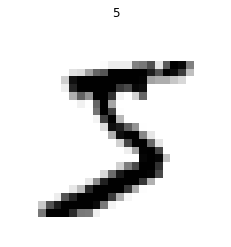

In [4]:
ax = plt.subplot(111)
ax.imshow(X_vis.loc[0,:].values.reshape(w, h), cmap=plt.cm.gray_r)
ax.set_title(y_vis.loc[0])
ax.set_axis_off();

We're going to plot images often, so it might help to have a function for this. Define a function plot_image using the following prototype:

In [2]:
def plot_image(img, reshape_size=None, cmap="binary", ax=None, title=None):
  if ax is None:
    ax = plt.subplot(111)
  if reshape_size is not None:
    img = img.values.reshape(*reshape_size)
  ax.imshow(img, cmap=cmap)
  if title is not None:
    ax.set_title(title)
  ax.set_axis_off();
  return ax

<AxesSubplot:title={'center':'5'}>

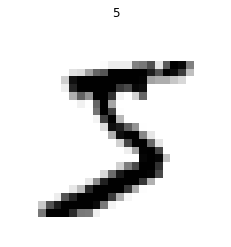

In [6]:
plot_image(X_vis.loc[0, :], reshape_size=(w, h), cmap=plt.cm.gray_r, title=y_vis[0])

Now you can use this function to plot a bunch of images from the dataset in a grid and have a feeling of what MNIST digits look like. you can play around with the parameters such as colormaps, grid size, etc..

You can use the [`plt.subplots`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots.html) from matplotlib to draw several axes on the same figure.

Text(0.5, 0.98, 'MNIST')

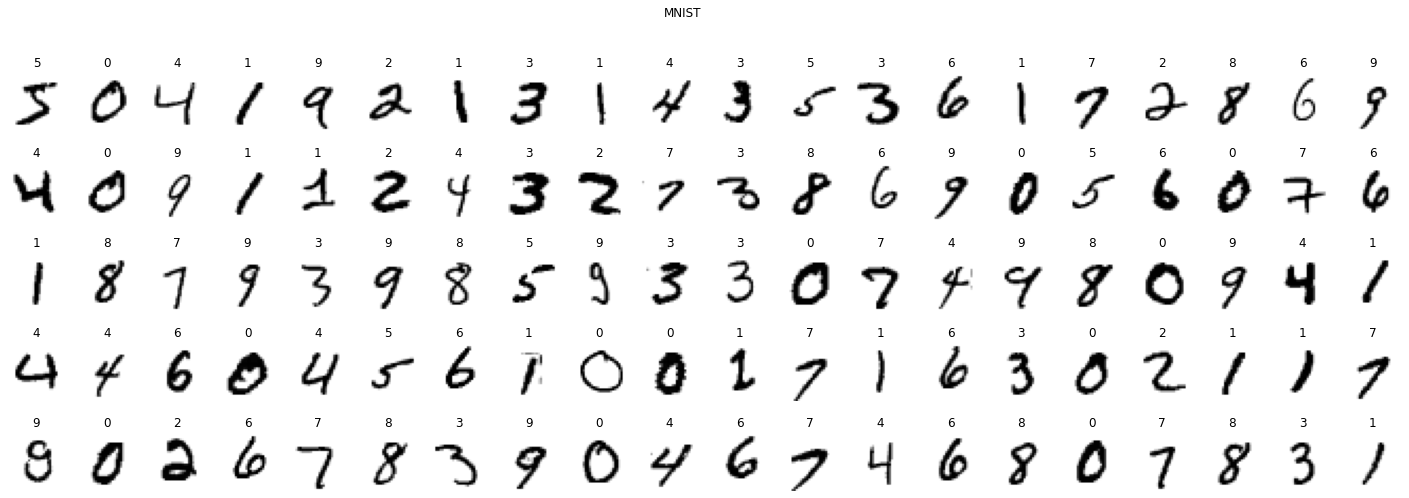

In [7]:
n_img_per_row = 20
fig, axes = plt.subplots(n_img_per_row // 4, n_img_per_row, figsize=(25,8))
for i in range(n_img_per_row // 4):
  for j in range(n_img_per_row):
    im_index = n_img_per_row * i + j
    plot_image(X_vis.loc[im_index], 
               reshape_size=(w, h),
               #cmap=plt.cm.gray_r,
               ax=axes[i, j],
               title=y_vis[im_index])
plt.suptitle("MNIST")

## High-dimensional projections to 2D

In this exercise we are going to use classical methods to visualize MNIST data in 2D.

The following sample code is adapted from the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py).

What is the original dimension of MNIST features?

In [8]:
X_vis.shape[1]

784

We define a helper function to plot the digits in `y` at positions in `X2d`. The goal of the exercise is to compute different 2D positions for the same original image vectors and get an intuition about how useful they are.

In [3]:
def plot_digits_embedding(X2d, y, title=None, remove_ticks=True):
  """
  Plot a 2D points at positions `X2d` using text labels from `y`.
  The data is automatically centered and rescaled to [0,1].
  Ticks are removed by default since the axes usually have no meaning (except for PCA).
  """
  x_min, x_max = np.min(X2d, 0), np.max(X2d, 0)
  X = (X2d - x_min) / (x_max - x_min)

  plt.figure(figsize=(20,10))
  ax = plt.subplot(111)
  for i in range(X.shape[0]):
    plt.text(X[i, 0], X[i, 1], str(y[i]),
                color=plt.cm.tab10(y[i]),
                fontdict={'weight': 'bold', 'size': 9})

  if remove_ticks:
    plt.xticks([]), plt.yticks([])
  if title is not None:
    plt.title(title)

We start with a random projection. Even though projecting randomly in 2 dimensions is a rather bad idea, when the original dimension is huge, a random projection to a smaller, still high, dimension might give a nice speedup.

Computing random projection


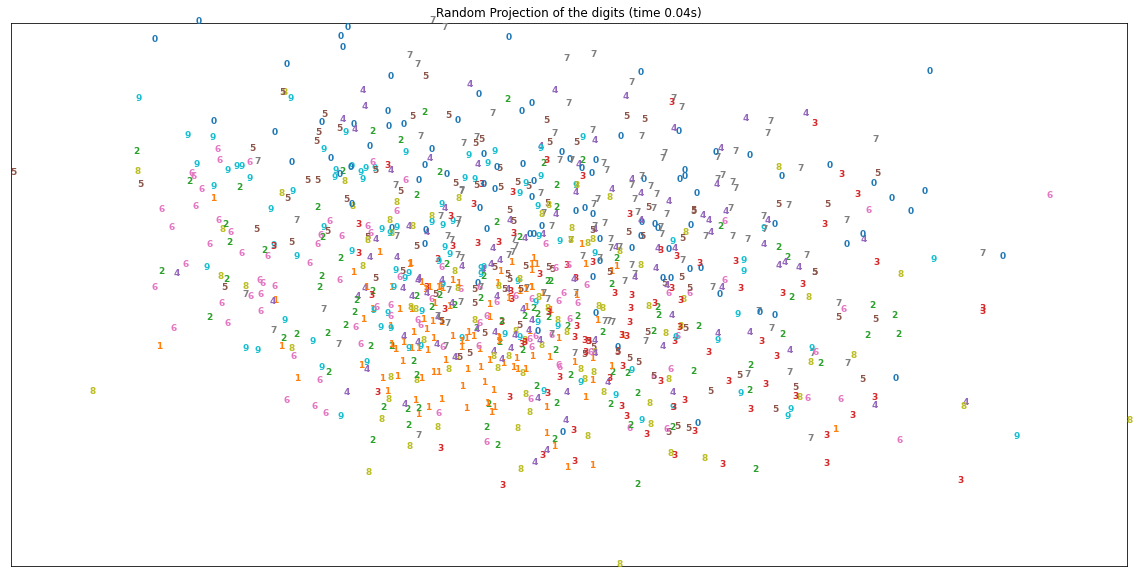

In [10]:
print("Computing random projection")
t0 = time()
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X_vis)
plot_digits_embedding(X_projected, y_vis, "Random Projection of the digits (time %.2fs)" %
               (time() - t0))


### PCA

PCA is the go-to method for dimensionality reduction (not only for visualisation). Play around with it to get a feel of how it works.

You can use scikit-learn's PCA. What is it using under the hood?

Computing PCA projection


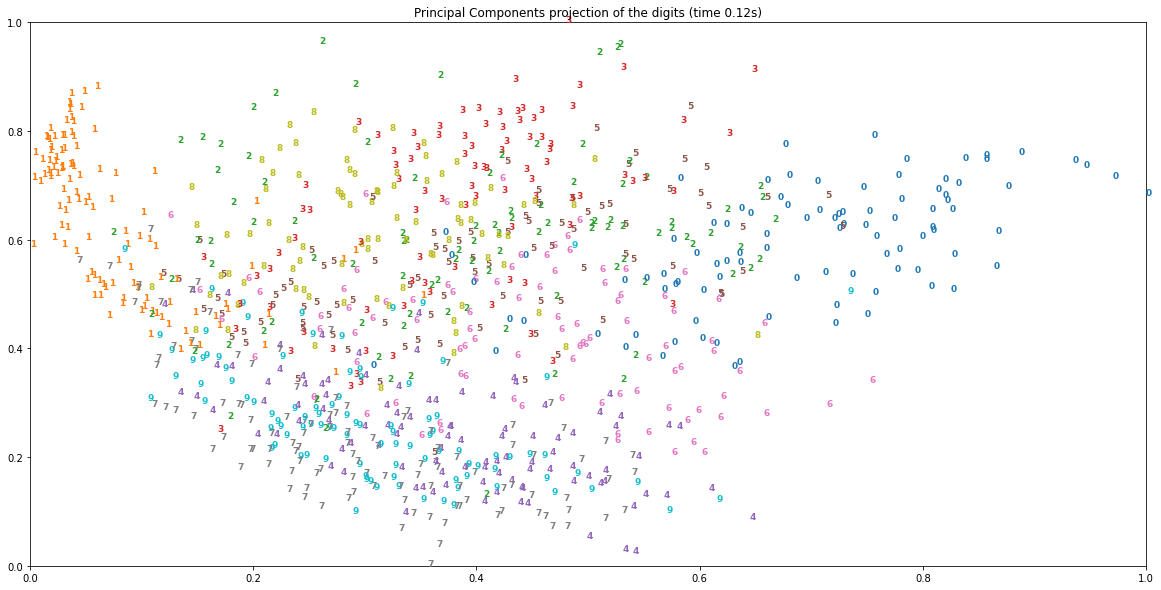

In [11]:
print("Computing PCA projection")
t0 = time()
pca = decomposition.PCA(n_components=2, svd_solver="arpack")
X_pca = pca.fit_transform(X_vis)
plot_digits_embedding(X_pca, y_vis, 
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0),
               remove_ticks=False)

*Note that zeros are mostly on the X-axis (around 0.8, 06) and ones are mostly on the second (0, 0.8)*

Compare the different `svd_solver` efficiency. `%timeit` is a notebook magic that allows you to compute the time taken by a line of code. Which method is best if you use the full dataset, vs only a few? (a few: arpack or randomized, full: randomized)

In [12]:
%timeit decomposition.PCA(n_components=2, svd_solver="full").fit_transform(X)

16.5 s ± 487 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit decomposition.PCA(n_components=2, svd_solver="arpack").fit_transform(X)

4.41 s ± 425 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit decomposition.PCA(n_components=2, svd_solver="randomized").fit_transform(X)

5.3 s ± 371 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Since PCA is a linear decomposition, each component is itself an image. Let's have a look at these "eigenimages". They are stored in the `components_` attribute of the sklearn `PCA` object.

<AxesSubplot:title={'center':'PCA second axis'}>

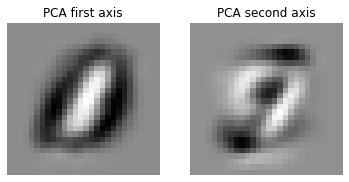

In [15]:
ax = plt.subplot(121)
plot_image(pca.components_[0,:].reshape(w, h), ax=ax, title="PCA first axis")
ax=plt.subplot(122)
plot_image(pca.components_[1,:].reshape(w, h), ax=ax, title="PCA second axis")

Do you think the projection is good? Can you quantify how good it is? How can you explain this? 

In [16]:
pca.explained_variance_ratio_

array([0.09931776, 0.07755832])

_PCA_ is limited to linear transformations of the data. There is little chance that you could find only 2 directions to span images which live in a high-dimensional space. 
Can non-linear methods give us better results here?

### Multidimensional Scaling (MDS)

Computing MDS embedding
Done. Stress: 7615875.024567


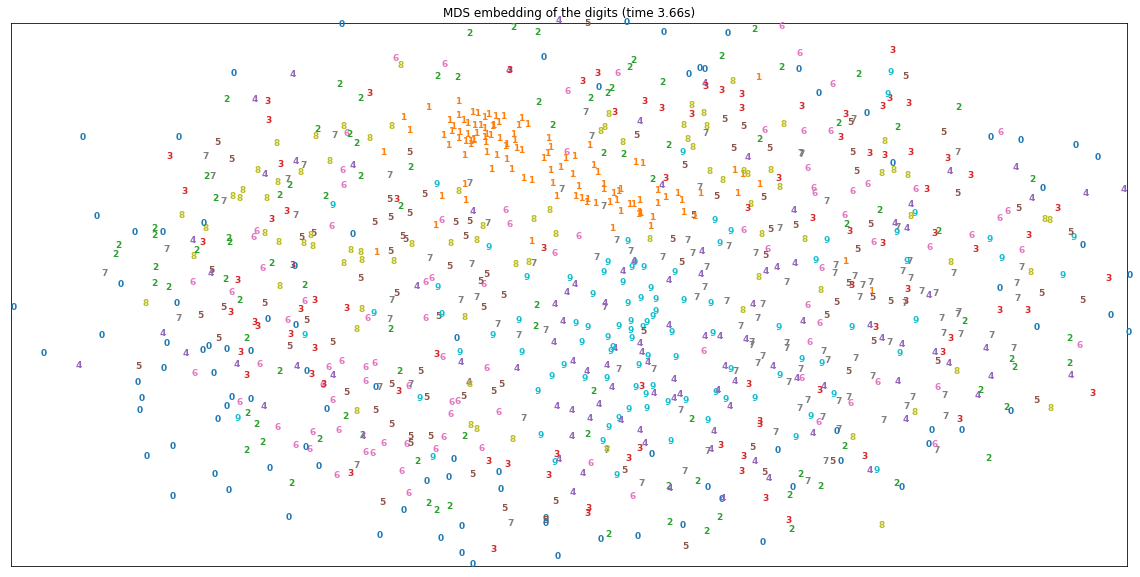

In [7]:
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X_vis)
print("Done. Stress: %f" % clf.stress_)
plot_digits_embedding(X_mds[:n_vis_samples], y_vis, 
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))

*Pas très convaincant, bien qu'on voie quelques chiffres se regrouper.*

### t-SNE

Play with the various parameters and observe how time/cluster change. [Scikit-learn documentation](https://scikit-learn.org/stable/modules/manifold.html#t-sne) is a good starting point if you want to know more.

- perplexity (`perplexity`)
- early exaggeration factor (`early_exaggeration`)
- learning rate (`learning_rate`)
- maximum number of iterations (`n_iter`)
- angle (`angle`, not used in the exact method)

Which parameters have more impact?

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


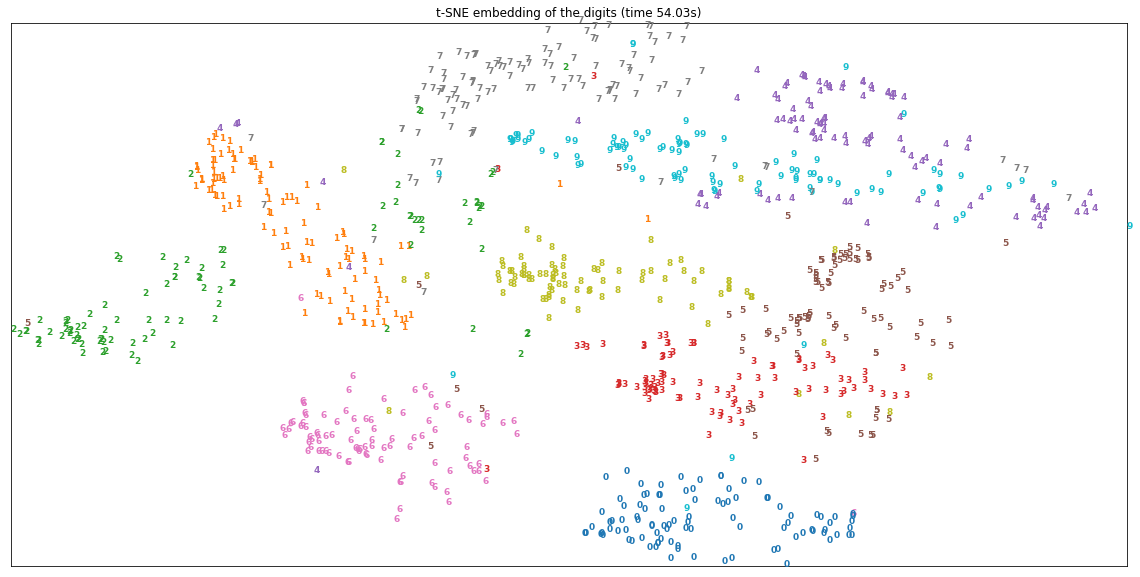

In [18]:
tsne = manifold.TSNE(n_components=2, init='random', random_state=42, perplexity=30)
t0 = time()

X_tsne = tsne.fit_transform(X[:5000]) 

plot_digits_embedding(X_tsne[:n_vis_samples], y_vis, 
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))


### UMAP

UMAP is not yet integrated into scikit-learn but is available as a standalone library that follows the sklearn API. You can have a look at [their doc](https://umap-learn.readthedocs.io/en/latest/parameters.html) to get a better understanding of the parameters.

In [16]:
!pip install umap-learn # run this if you run into an "ModuleNotFoundError: No module named 'umap'" error below

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=13b393d6722157e3af8f44e91eae9006686d59060a81580bb06525fa0687acbc
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=ce27314a4740727004ec923c6c5783fabf7b9f59593d3a4519bfa1857954a3c7
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


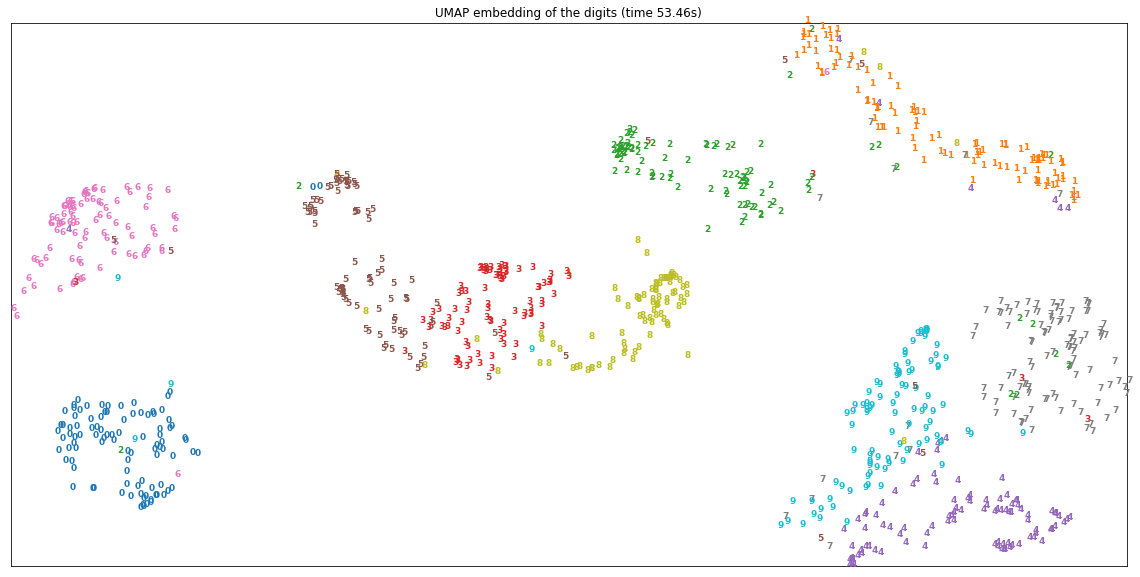

In [10]:
import umap
t0 = time()
um = umap.UMAP(n_neighbors=10, min_dist=0.1, metric="euclidean")
#um.fit_transform(X_vis)  # faster, but fitting with more samples below give a cleaner output
X_umap = um.fit_transform(X[:5000])
t1 = time()
fig_umap = plot_digits_embedding(X_umap[:n_vis_samples], y_vis, 
               "UMAP embedding of the digits (time %.2fs)" %
               (t1 - t0))

In this example, UMAP yields a much cleaner plot, and is faster.

If time permits, you can try combining the methods above: for instance, use PCA to reduce the dimensionality to accelerate either MDS or tSNE. What do you observe?

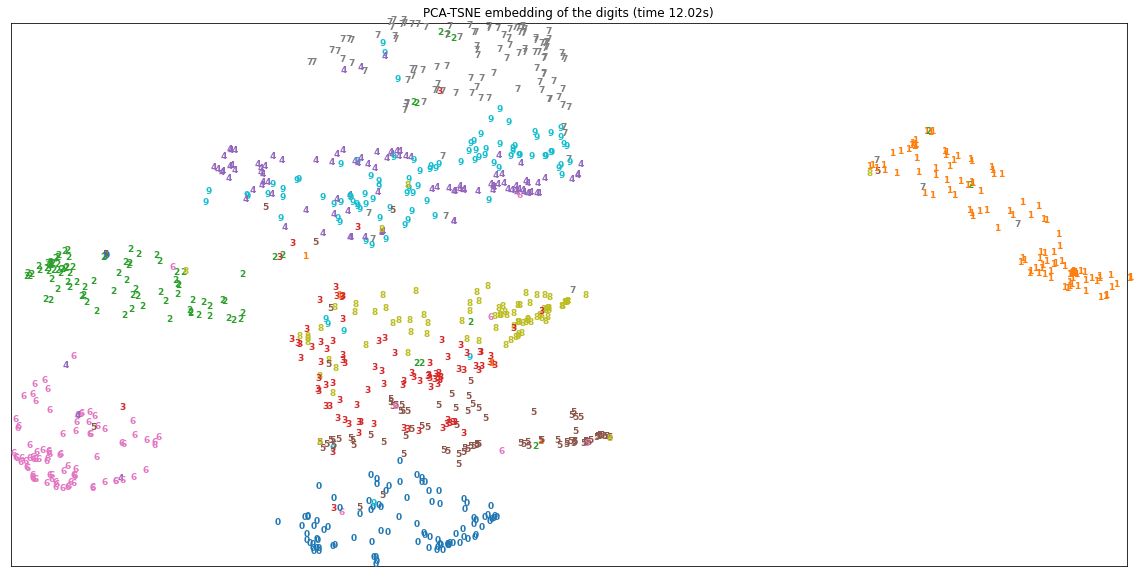

In [11]:
#TODO_OPTIONAL
t0 = time()
# Use PCA to get only 50 dimensions, then UMAP
pca = decomposition.PCA(n_components=10, svd_solver="auto")
um = umap.UMAP(n_neighbors=10, min_dist=0.1, metric="euclidean")

X_pca = pca.fit_transform(X[:5000])
X_umap = um.fit_transform(X_pca) 
t1 = time()
fig_tsne_pca = plot_digits_embedding(X_umap[:n_vis_samples], y_vis, 
               "PCA-TSNE embedding of the digits (time %.2fs)" %
               (t1 - t0))


*The result is about the same as with TSNE, but twice faster. Note that 784 is not that big and the speed-up may vary depending on the methods you use, especially as it also depends on the number of points.*

# 2. Visualizing and debugging neural networks

In the next section, we're going to reproduce what you're learnt before in your machine learning courses with a focus on the visualizing part of it. You should come out with handy functions that you can reuse later for your own experiments.

We will use Fashion-MNIST because that's more fun to visualize.

Build an image classifier & visualize layers

In [4]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# adapted from https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
assert tf.__version__ >= "2.0"

from tensorflow import keras

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [6]:
tf.__version__

'2.11.0'

In [7]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [8]:
X_train_full.dtype

dtype('uint8')

In [9]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [10]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

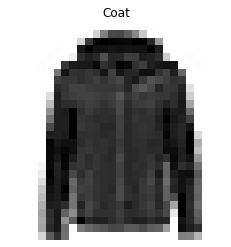

In [11]:
plot_image(X_train[0], reshape_size=None, cmap="binary", ax=None, title=class_names[y_train[0]]);

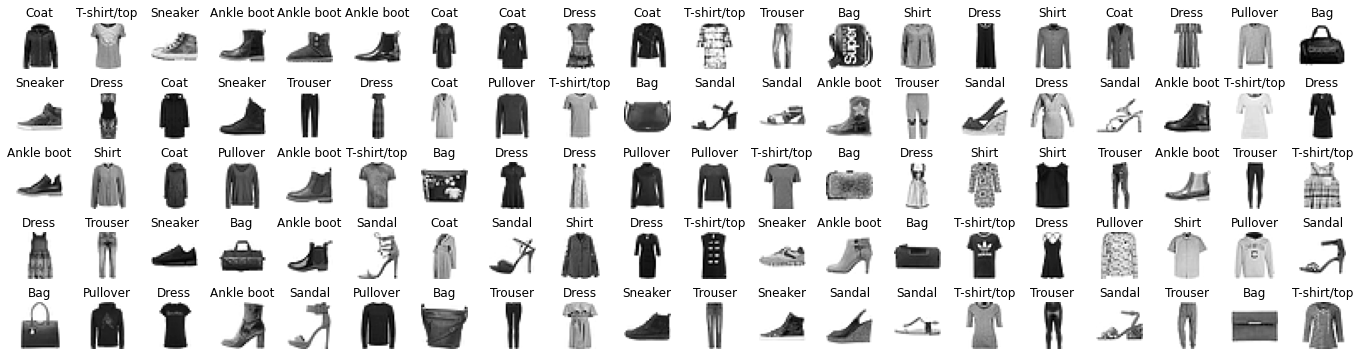

In [12]:
n_rows = 5
n_cols = 20
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        ax = plt.subplot(n_rows, n_cols, index + 1)
        plot_image(X_train[index], ax=ax, title=class_names[y_train[index]]);
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [13]:
n_vis_samples = 1000
X_vis = X_test[:n_vis_samples]
y_vis = y_test[:n_vis_samples]
X_in = X_vis.reshape(n_vis_samples, 28*28)

In [14]:
def plot_interactive_embedding(X2d, y, title=None, remove_ticks=True):
  """
  Plot a 2D points at positions `X2d` using text labels from `y`.
  The data is automatically centered and rescaled to [0,1].
  Ticks are removed by default since the axes usually have no meaning (except for PCA).
  """
  x_min, x_max = np.min(X2d, 0), np.max(X2d, 0)
  X = (X2d - x_min) / (x_max - x_min)

  plt.figure(figsize=(20,10))
  ax = plt.subplot(111)
  for i in range(X.shape[0]):
    plt.text(X[i, 0], X[i, 1], str(y[i]),
                color=plt.cm.tab10(y[i]),
                fontdict={'weight': 'bold', 'size': 9})

  if remove_ticks:
    plt.xticks([]), plt.yticks([])
  if title is not None:
    plt.title(title)

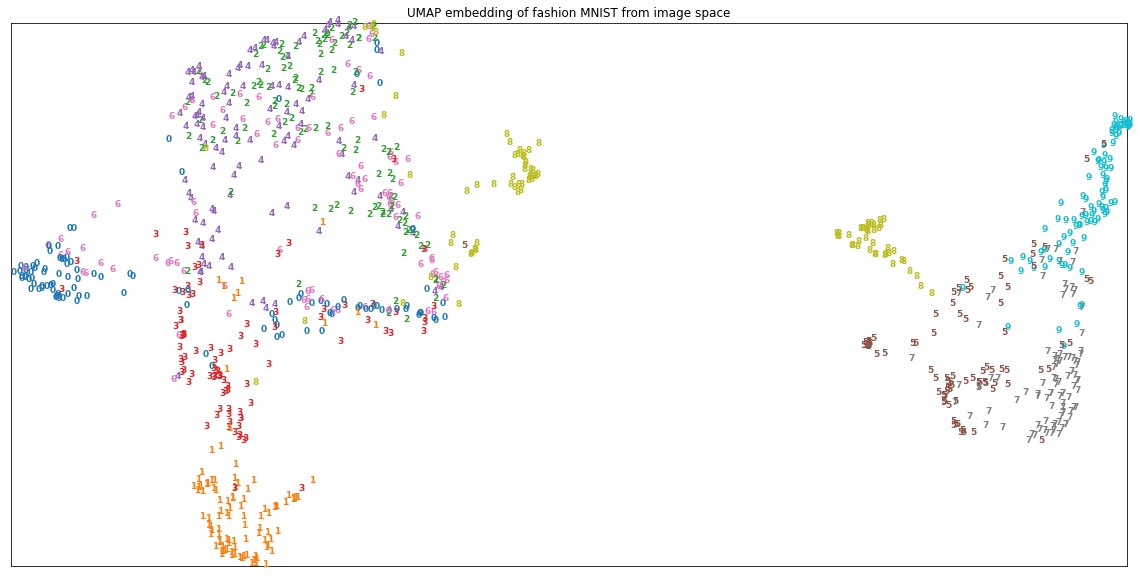

In [18]:
import umap
um = umap.UMAP(n_neighbors=20, min_dist=0.1, metric="euclidean")
X_2D = um.fit_transform(X_in)
plot_interactive_embedding(X_2D, y_vis, 
               "UMAP embedding of fashion MNIST from image space")


## A simple fully connected neural network

In [19]:
model_fc = keras.models.Sequential()
model_fc.add(keras.layers.Flatten(input_shape=[28, 28]))
model_fc.add(keras.layers.Dense(50, activation="relu", name="fc1"))
model_fc.add(keras.layers.Dense(100, activation="relu", name="fc2"))
model_fc.add(keras.layers.Dense(10, activation="softmax", name="cls_1"))

In [20]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

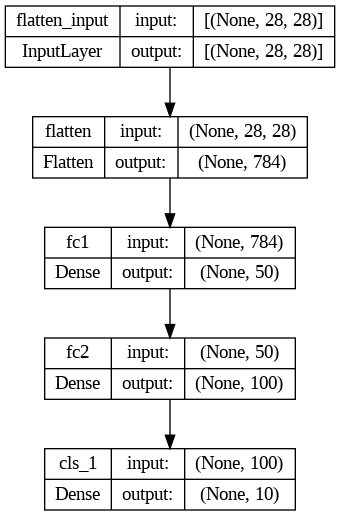

In [21]:
keras.utils.plot_model(model_fc, "my_mnist_model.png", show_shapes=True)

In [22]:
model_fc.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

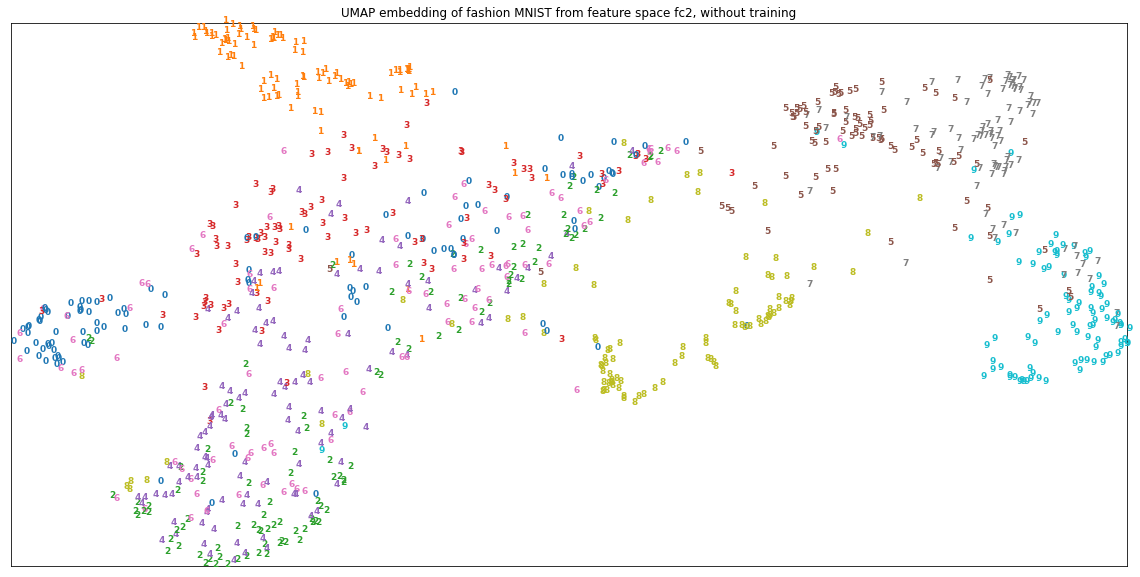

In [25]:
# before fitting
layer_to_plot = ["fc1", "fc2"]
features = {}
X_in = X_vis.reshape(n_vis_samples, 28*28)
for l in model_fc.layers:
  X_out = l(X_in)
  X_in = X_out
  if l.name in layer_to_plot:
    features[l.name] = X_out

X_2D = um.fit_transform(features["fc2"])
fig_2D_fc2_rand = plot_interactive_embedding(X_2D, y_vis,
               "UMAP embedding of fashion MNIST from feature space fc2, without training")

*This is not exactly like a random projection, but basically it doesn't look like the structure of the data has changed much.*

In [26]:
# training takes about 1 minute
history = model_fc.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 10s 4ms/step - loss: 0.8343 - accuracy: 0.7208 - val_loss: 0.5759 - val_accuracy: 0.8002
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5293 - accuracy: 0.8144 - val_loss: 0.4723 - val_accuracy: 0.8394
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4742 - accuracy: 0.8314 - val_loss: 0.5854 - val_accuracy: 0.7804
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4444 - accuracy: 0.8434 - val_loss: 0.4231 - val_accuracy: 0.8540
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4252 - accuracy: 0.8486 - val_loss: 0.4069 - val_accuracy: 0.8562
Epoch 6/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4070 - accuracy: 0.8563 - val_loss: 0.3999 - val_accuracy: 0.8574
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3953 - accuracy: 0.8595 - val_loss: 0.3905 - val_accuracy

### Looking at the learned weights directly

The first layer's weights is a $784\times h$ matrix, so we can observe a few lines of this matrix as images. Can you see patterns emerge?

*It looks like most of the work is done by the first layer -- this may need the network needs longer training time, or better tuning.*

In [48]:
layer_weights = model_fc.get_weights()
len(layer_weights), layer_weights[0].shape, layer_weights[1].shape, layer_weights[2].shape

(6, (784, 50), (50,), (50, 100))

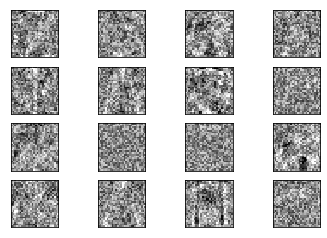

In [49]:
fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = layer_weights[0].min(), layer_weights[0].max()

for coef, ax in zip(layer_weights[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

*Even though the images are very noisy, this doesn't look like pure noise, there are indeed faint patterns encoded in the first layer's parameters.*

### Looking at the latent representations

Another way to look at the intermediate layers is through their effect as feature transforms.

Plot a view of the points as transformed at different levels in the network. What can you observe?

_We would expect that categories get easier to separate as we go deeper in the network_.

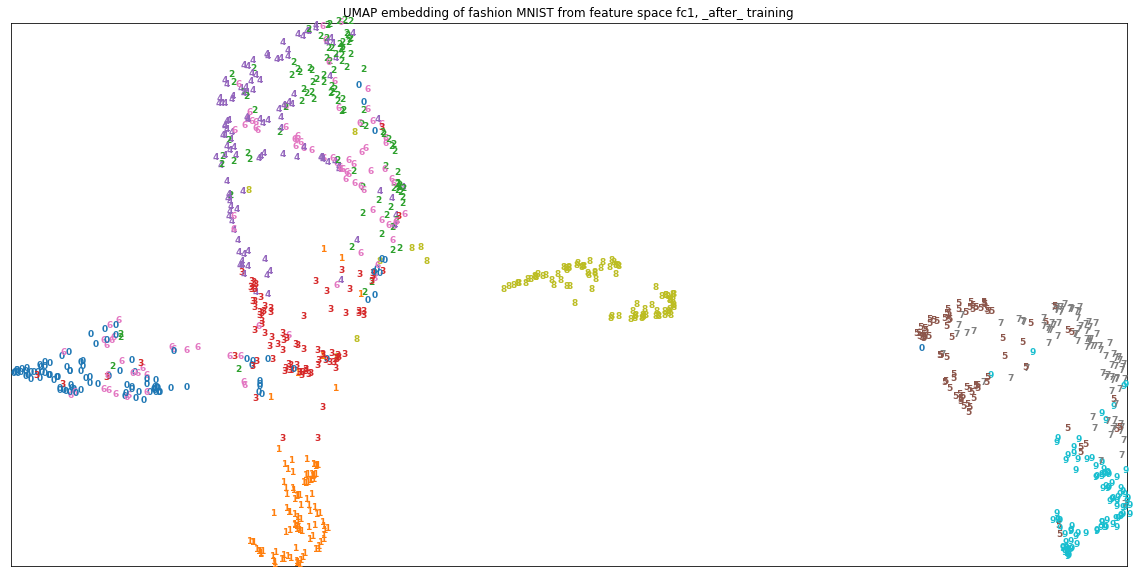

In [28]:
# after fitting
layer_to_plot = ["fc1", "fc2"]
features = {}
X_in = X_vis.reshape(n_vis_samples, 28*28)
for l in model_fc.layers:
  X_out = l(X_in)
  X_in = X_out
  if l.name in layer_to_plot:
    features[l.name] = X_out


X_2D = um.fit_transform(features["fc1"])
fig_2D_fc1 = plot_interactive_embedding(X_2D, y_vis, 
               "UMAP embedding of fashion MNIST from feature space fc1, _after_ training")


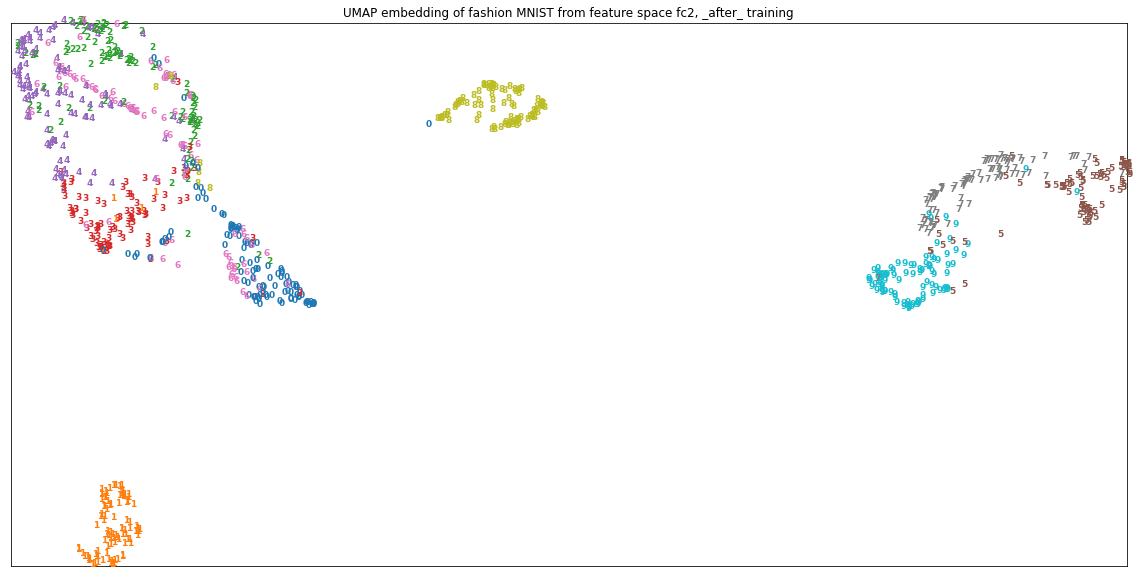

In [29]:
X_2D = um.fit_transform(features["fc2"])
fig_2D_fc2 = plot_interactive_embedding(X_2D, y_vis, 
               "UMAP embedding of fashion MNIST from feature space fc2, _after_ training")

### Debugging Learning

Plot the learning curve from the history output of the `fit` call. What do you observe?

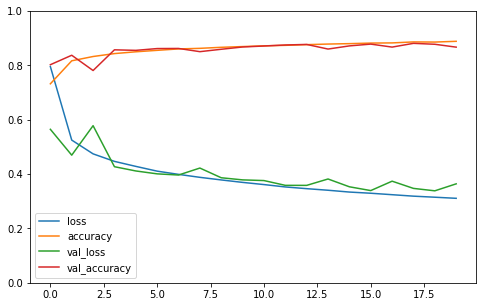

<Figure size 432x288 with 0 Axes>

In [53]:
import pandas as pd
import seaborn as sns

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.gca().set_ylim(0, 1)
plt.show()
sns.despine()

_Answer: the learning curve is plateauing, it might be a good idea to lower the learning rate (ReduceLROnPlateau, or use some schedule)._


### What do predictions look like?

In this part, we're going to look at the output of the classification model itself.

In [54]:
# Look at a few random predictions
n_test = 10
X_new = X_test[:n_test]
y_proba = model_fc.predict(X_new)
y_proba.round(2)
y_pred = np.argmax(model_fc.predict(X_new), axis=-1)

1/1 [==============================] - 0s 45ms/step


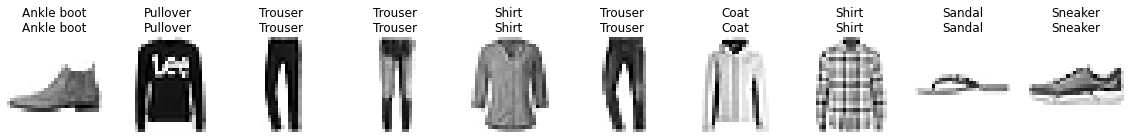

In [55]:
# This could be turned into a function
plt.figure(figsize=(20, 3))
for index, image in enumerate(X_new):
    ax = plt.subplot(1, n_test, index + 1)
    title="\n".join((class_names[y_test[index]], class_names[y_pred[index]]))
    plot_image(image, ax=ax, title=title);
plt.show()

#### The distribution of predictions

You can use `seaborn`, `bokeh`, or raw `matplotlib` to view these distributions. It might be useful to organise the predictions with dataframes.

1. Which classes are predicted the more, the less?
2. What is the distribution of the predicted probabilities for each class? Do you see any trend? Does it raise questions?

In [30]:
# compute test predictions
y_proba_test = model_fc.predict(X_test)
y_pred = y_proba_test.argmax(axis=-1)

313/313 [==============================] - 1s 2ms/step


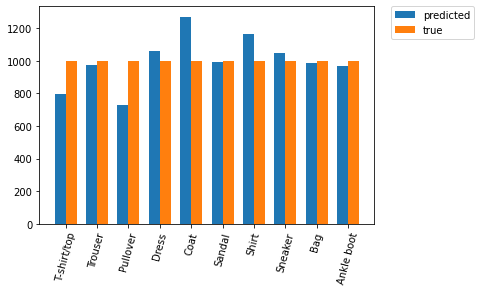

In [31]:
ax = plt.subplot(111)
ax.hist([y_pred.astype(int), y_test], rwidth=0.7, bins=np.arange(11), label=['predicted', 'true'])
ax.set_xticks(np.array(range(10))+0.5)
plt.xticks(rotation=75)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xticklabels(class_names);

*Answer 1: Pullover is under-predicted, while Coat is overpredicted.*

In [34]:
import pandas as pd

In [41]:
# looking at all the probabilities output vectors
# we expect something like 90% close to 0, 10% close to one, maybe more in-between if there is uncertainty in predictions
df = pd.DataFrame(data=y_proba_test, columns=class_names)
df = df.stack()
df

0     T-shirt/top    0.000019
      Trouser        0.000003
      Pullover       0.000041
      Dress          0.000015
      Coat           0.000006
                       ...   
9999  Sandal         0.995916
      Shirt          0.000169
      Sneaker        0.003558
      Bag            0.000189
      Ankle boot     0.000038
Length: 100000, dtype: float32

In [42]:
df.index.names = ["id", "class_name"]
df.name = "predicted"
df_tidy = df.reset_index(level=1)

In [36]:
df2 = pd.DataFrame(data=y_test, columns=["true"])
df_tidy = df.reset_index(level=1).join(df2)
df_tidy.sort_values(by="class_name", inplace=True)

In [37]:
df_tidy.head()

,class_name,predicted,true
4999,Ankle boot,8.639797e-05,7
3930,Ankle boot,1.299580e-05,3
3931,Ankle boot,2.684210e-07,3
3932,Ankle boot,1.413161e-11,2
3933,Ankle boot,1.820752e-08,2


In [38]:
df_tidy

,class_name,predicted,true
4999,Ankle boot,8.639797e-05,7
3930,Ankle boot,1.299580e-05,3
3931,Ankle boot,2.684210e-07,3
3932,Ankle boot,1.413161e-11,2
3933,Ankle boot,1.820752e-08,2
...,...,...,...
6783,Trouser,3.881289e-05,7
4086,Trouser,2.589563e-06,7
4085,Trouser,7.224869e-06,8
4089,Trouser,7.686749e-08,7


In [61]:
df_tidy.groupby("class_name").describe()

predicted                                                  \
                count      mean       std           min           25%   
class_name                                                              
Ankle boot    10000.0  0.095515  0.281190  7.732884e-15  2.960385e-09   
Bag           10000.0  0.098170  0.287049  1.165865e-11  8.642607e-06   
Coat          10000.0  0.132952  0.288365  1.417583e-16  4.785196e-06   
Dress         10000.0  0.101553  0.269340  1.514296e-17  1.838904e-06   
Pullover      10000.0  0.069149  0.198692  2.615072e-17  1.163500e-06   
Sandal        10000.0  0.100426  0.286995  3.962771e-14  7.557439e-09   
Shirt         10000.0  0.116829  0.238883  6.916450e-16  2.336448e-06   
Sneaker       10000.0  0.105138  0.290308  2.452172e-17  5.895293e-09   
T-shirt/top   10000.0  0.080366  0.225500  9.186388e-13  5.120106e-06   
Trouser       10000.0  0.099902  0.292274  5.423674e-15  8.833263e-07   

                                                  true                      \
                      50%       75%       max    count mean       std  min   
class_name                                                                   
Ankle boot   5.122702e-07  0.000211  0.999995  10000.0  4.5  2.872425  0.0   
Bag          1.228215e-04  0.001672  1.000000  10000.0  4.5  2.872425  0.0   
Coat         3.960920e-04  0.044575  0.999481  10000.0  4.5  2.872425  0.0   
Dress        8.864397e-05  0.004848  0.999915  10000.0  4.5  2.872425  0.0   
Pullover     3.861936e-04  0.010989  0.998140  10000.0  4.5  2.872425  0.0   
Sandal       3.060280e-06  0.000991  1.000000  10000.0  4.5  2.872425  0.0   
Shirt        1.426788e-03  0.080080  0.999127  10000.0  4.5  2.872425  0.0   
Sneaker      1.090405e-06  0.000574  0.999951  10000.0  4.5  2.872425  0.0   
T-shirt/top  1.583686e-04  0.005361  0.999727  10000.0  4.5  2.872425  0.0   
Trouser      3.112476e-05  0.001148  0.999999  10000.0  4.5  2.872425  0.0   

                                 
             25%  50%  75%  max  
class_name                       
Ankle boot   2.0  4.5  7.0  9.0  
Bag          2.0  4.5  7.0  9.0  
Coat         2.0  4.5  7.0  9.0  
Dress        2.0  4.5  7.0  9.0  
Pullover     2.0  4.5  7.0  9.0  
Sandal       2.0  4.5  7.0  9.0  
Shirt        2.0  4.5  7.0  9.0  
Sneaker      2.0  4.5  7.0  9.0  
T-shirt/top  2.0  4.5  7.0  9.0  
Trouser      2.0  4.5  7.0  9.0

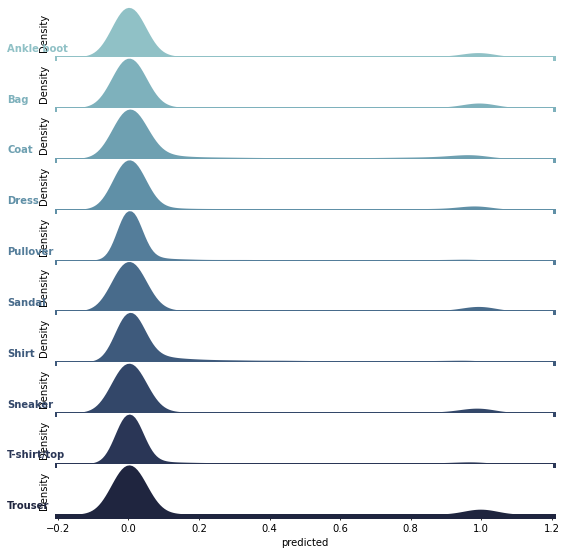

In [62]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    
# adapted from https://seaborn.pydata.org/examples/kde_ridgeplot.html
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_tidy, row="class_name", hue="class_name", aspect=10, height=0.8, palette=pal, sharey=False)

# Draw the densities in a few steps
#g.map(sns.distplot, "predicted", kde=False, hist=True, rug=False, bins=100)
g.map(sns.kdeplot, "predicted", clip_on=False, shade=True, alpha=1, lw=3) #, bw=.05)
g.map(plt.axhline, y=0, lw=5, clip_on=False)

g.map(label, "predicted")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.02)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

*Answer 2 (trends): Unless you use a different scale on the y-axis, you can't see much differnce between classes, only that the divide is so clear between high and low predictions.
Looking with different scales helps: the classification is much easier for some classes (as could be expected by looking at the clusters on the feature projections).*

*Next we'll restrict to the max proba for each sample to zoom on the proba of actual predictions.*

In [63]:
y_proba_max = y_proba_test[np.arange(len(y_pred)), y_pred]
df = pd.DataFrame(data=np.array([y_proba_max, y_pred, y_test]).T, columns=["proba", "predicted", "true"])
df[["predicted", "true"]] = df[["predicted", "true"]].astype(int)
df["class_name"] = df["predicted"].apply(lambda x: class_names[x])
df.sort_values(by="class_name", inplace=True)
df.head()

,proba,predicted,true,class_name
0,0.868758,9,9,Ankle boot
2379,0.997323,9,9,Ankle boot
2370,0.998393,9,9,Ankle boot
2365,0.998788,9,9,Ankle boot
7983,0.695917,9,9,Ankle boot


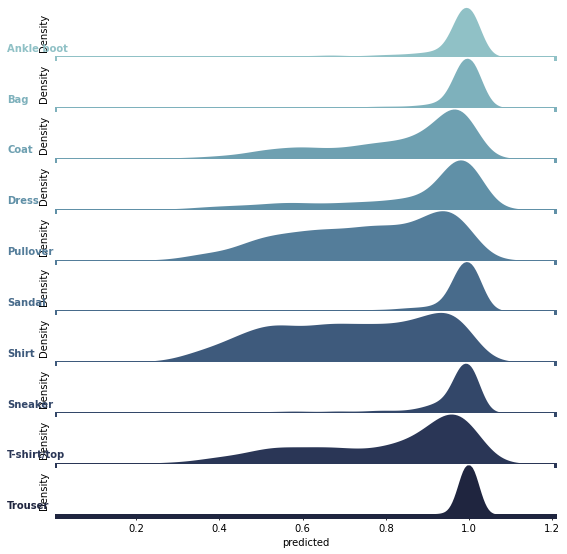

In [64]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="class_name", hue="class_name", aspect=10, height=0.8, palette=pal, sharey=False)

# Draw the densities in a few steps
#g.map(sns.distplot, "predicted", kde=False, hist=True, rug=False, bins=100)
g.map(sns.kdeplot, "proba", clip_on=False, shade=True, alpha=1, lw=3) #, bw=.05)
g.map(plt.axhline, y=0, lw=5, clip_on=False)
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "predicted")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.02)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

*There are clearly 2 kinds of classes: the easy ones (Ankle boot, Bag, Sandal, Sneaker, Trouser) and the hard ones, especially Shirt and Pullover.*

*We expect to see this in other ways below*.

#### Which examples are the hardest to classify?

Plot hard example and check whether you'd agree with the model (that they are hard).

In [43]:
# Find worst mistakes
y_proba_test = model_fc.predict(X_test)
mistakes = np.squeeze(np.argwhere(y_pred != y_test))
worst_mistakes = np.argsort(-y_proba_test[mistakes,:].max(axis=1))[:n_test]

313/313 [==============================] - 1s 2ms/step


NameError: ignored

In [44]:
y_pred[mistakes[:10]], y_test[mistakes[:10]]

(array([5, 2, 5, 2, 4, 6, 6, 6, 3, 4]),
 array([7, 4, 9, 4, 3, 3, 2, 4, 2, 3], dtype=uint8))

In [45]:
y_pred[worst_mistakes], y_test[worst_mistakes]

NameError: ignored

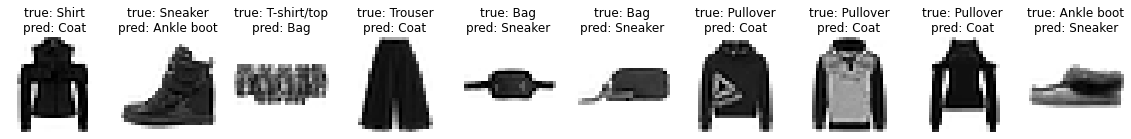

In [68]:
plt.figure(figsize=(20, 3))
for i, index in enumerate(mistakes[worst_mistakes]):
    ax = plt.subplot(1, n_test, i + 1)
    title="\n".join((f"true: {class_names[y_test[index]]}", f"pred: {class_names[y_pred[index]]}"))
    plot_image(X_test[index], ax=ax, title=title);
plt.show()

#### Which classes are the most difficult to classify? The most confused?

This kind of question is best answered by looking at the confusion matrix. If you don't know how to do that, you can look at `sklearn.metrics.confusion_matrix` and `sns.heatmap` for help.

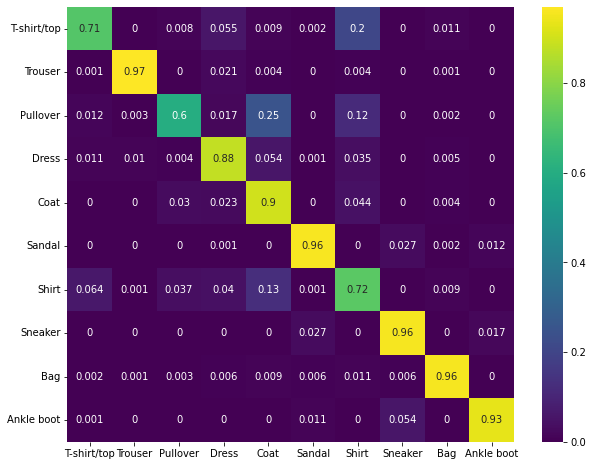

In [69]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, normalize="true")
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, cmap="viridis");

*We could almost tell it based on the distribution of probabilities: Pullover and Shirt/T-Shirt are the hardest, then Dress/Coat, the others are pretty easy.*

#Visualizing CNN models

In [46]:
from PIL import Image
from functools import partial
import os


In [47]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train_c = (X_train - X_mean) / X_std
X_valid_c = (X_valid - X_mean) / X_std
X_test_c = (X_test - X_mean) / X_std

X_train_c = X_train_c[..., np.newaxis]
X_valid_c = X_valid_c[..., np.newaxis]
X_test_c = X_test_c[..., np.newaxis]

In [48]:

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

feature_extractor = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
])
classifier = keras.models.Sequential([
    keras.layers.Dense(units=128, activation='selu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='selu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

model = keras.models.Sequential([feature_extractor, classifier])

*Let's first look at the embedding produced by _random_ convolution filters, yay!*.

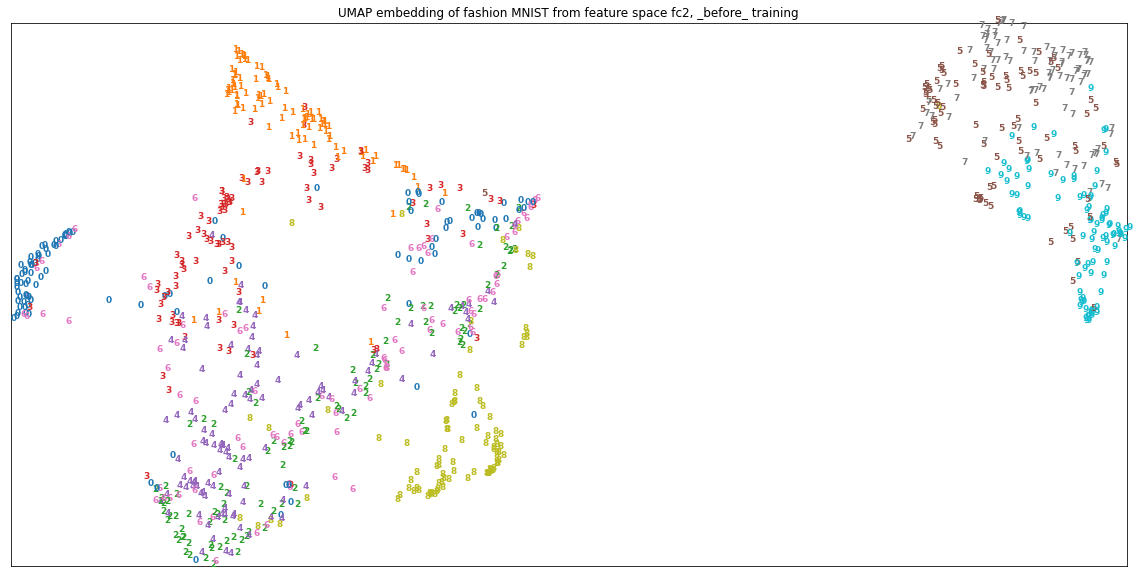

In [49]:
X_2D = um.fit_transform(feature_extractor(X_vis[:,:,:, np.newaxis]))
fig_2D_cnn = plot_interactive_embedding(X_2D, y_vis, 
               "UMAP embedding of fashion MNIST from feature space fc2, _before_ training")

*Plot the kernel weights (first layer only, but you get the idea). Before training, it is not very interesting, it's randomly initialized.*

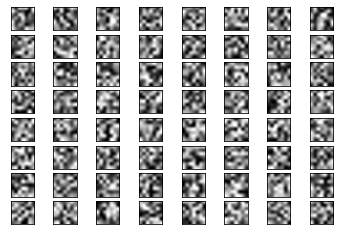

In [50]:
layer_weights = feature_extractor.get_weights()
fig, axes = plt.subplots(8, 8)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = layer_weights[0].min(), layer_weights[0].max()

for coef, ax in zip(layer_weights[0].T, axes.ravel()):
    k1 = (coef.reshape(7, 7) - vmin) / (vmax - vmin)
    im = Image.fromarray(k1 * 255)
    ax.imshow(im.resize((28,28)))
    ax.set_xticks(())
    ax.set_yticks(())


In [51]:
# This is much longer than the feed-forward network so we train only for 10 epochs
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train_c[:10000], y_train[:10000], epochs=10, validation_data=(X_valid_c, y_valid))

Epoch 1/10
313/313 [==============================] - 203s 636ms/step - loss: 0.8667 - accuracy: 0.6928 - val_loss: 0.4810 - val_accuracy: 0.8268
Epoch 2/10
313/313 [==============================] - 170s 542ms/step - loss: 0.5342 - accuracy: 0.8113 - val_loss: 0.3980 - val_accuracy: 0.8576
Epoch 3/10
313/313 [==============================] - 159s 508ms/step - loss: 0.4450 - accuracy: 0.8448 - val_loss: 0.4063 - val_accuracy: 0.8554
Epoch 4/10
313/313 [==============================] - 159s 507ms/step - loss: 0.3926 - accuracy: 0.8626 - val_loss: 0.3392 - val_accuracy: 0.8784
Epoch 5/10
313/313 [==============================] - 158s 503ms/step - loss: 0.3497 - accuracy: 0.8758 - val_loss: 0.3724 - val_accuracy: 0.8702
Epoch 6/10
313/313 [==============================] - 160s 511ms/step - loss: 0.3166 - accuracy: 0.8892 - val_loss: 0.3959 - val_accuracy: 0.8606
Epoch 7/10
313/313 [==============================] - 155s 494ms/step - loss: 0.2795 - accuracy: 0.9030 - val_loss: 0.3716 -

In [52]:
score = model.evaluate(X_test_c, y_test)
X_new = X_test_c[:10] # pretend we have new images
y_pred = model.predict(X_new)


1/1 [==============================] - 0s 169ms/step


You can redo the same visualization as with the feed-forward model. Instead of looking at weights as images, you can plot the CNN's kernel weights as tiny images.

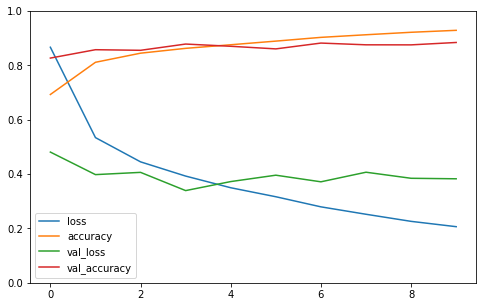

In [54]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.gca().set_ylim(0, 1)
plt.show()

*There is a risk of overfitting here... this is an example, hyper-parameters have not been tuned.*

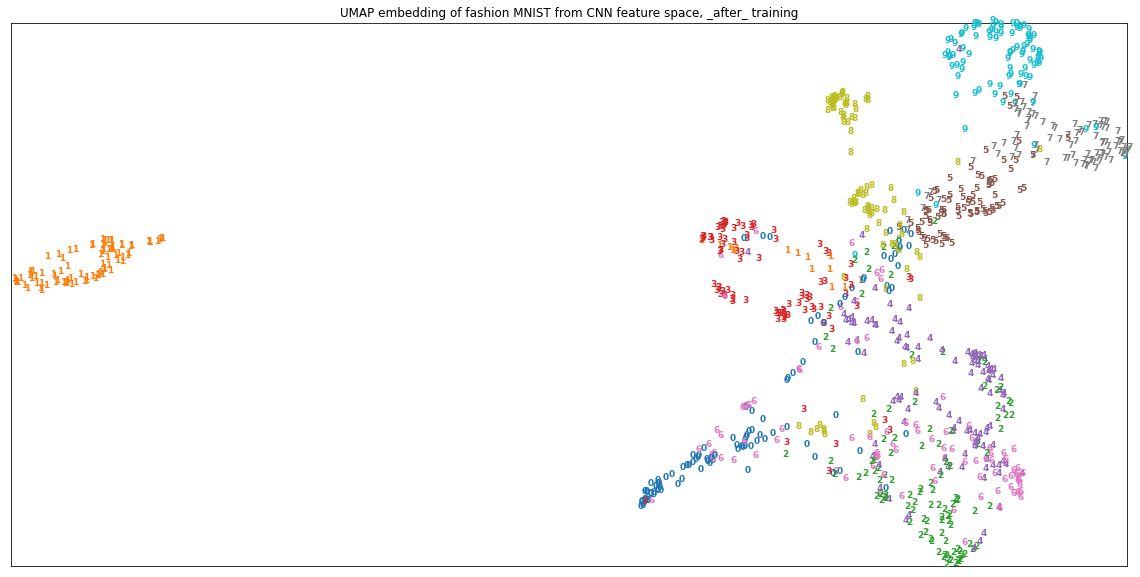

In [55]:
X_2D = um.fit_transform(feature_extractor(X_vis[:,:,:, np.newaxis]))
fig_2D_cnn = plot_interactive_embedding(X_2D, y_vis, 
               "UMAP embedding of fashion MNIST from CNN feature space, _after_ training")

In [60]:
layer_to_plot = ["sequential", "sequential_1"]
features = {}
X_in = X_vis
for l in model.layers:
  X_out = l(X_in)
  X_in = X_out
  print(l.name)
  if l.name in layer_to_plot:
    features[l.name] = X_out

sequential
sequential_1


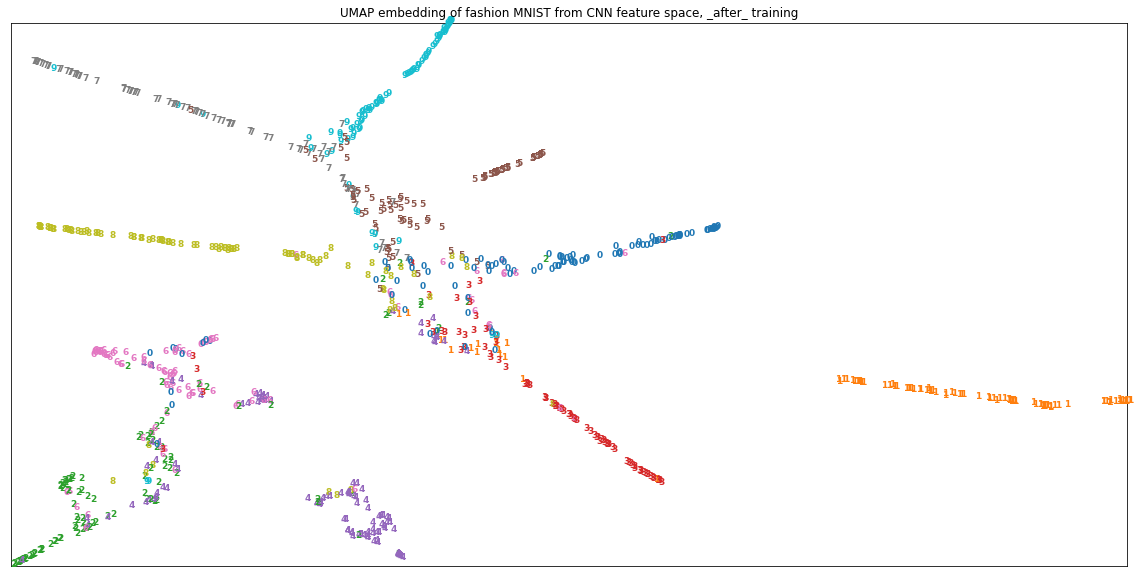

In [62]:
X_2D = um.fit_transform(features["sequential_1"])
fig_2D_fc2 = plot_interactive_embedding(X_2D, y_vis, 
               "UMAP embedding of fashion MNIST from CNN feature space, _after_ training")

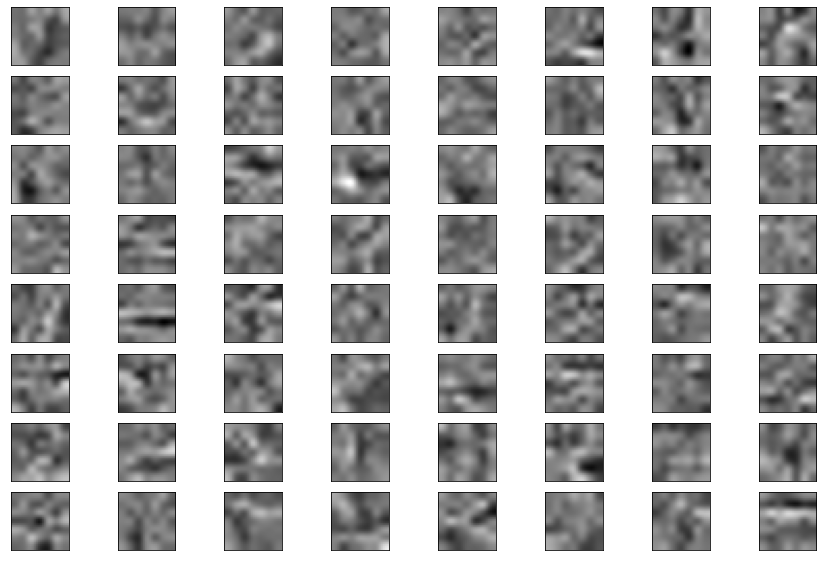

In [63]:
layer_weights = feature_extractor.get_weights()
fig = plt.figure(figsize=(15, 10))
axes = fig.subplots(8, 8)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = layer_weights[0].min(), layer_weights[0].max()

for coef, ax in zip(layer_weights[0].T, axes.ravel()):
    k1 = (coef.reshape(7, 7) - vmin) / (vmax - vmin)
    im = Image.fromarray(k1 * 255)
    ax.imshow(im.resize((28,28)))
    ax.set_xticks(())
    ax.set_yticks(())


*I have seen cleaner filters than this, but still, given that the network is not finely tuned, it's not bad: for instance we can observe some directional filters (vertical, diagnoal)*.

This is the most direct primitive way to watch at what the CNN does. Kernels are not always easy to interpret, especially when they combine to produce the results. Which is why people look at how they affect some test images. One example methods which is history already is DeepDream.

If time permits, you can go through the [DeepDream tutorial](https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/examples/tutorials/deepdream/deepdream.ipynb) and adapt it here to visualise the layers of your network.